In [ ]:
%pip install osmnx networkx matplotlib smolagents imageio "smolagents[litellm]" scikit-learn

In [33]:
import os
import osmnx as ox
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from difflib import get_close_matches
import imageio.v2 as imageio
from smolagents import CodeAgent, LiteLLMModel, Tool, FinalAnswerTool
from IPython.display import display

### Construção e visualização do grafo

In [3]:
filter = '["highway"~"primary|secondary|tertiary"]'

place_name = "Belo Horizonte, Minas Gerais, Brasil"

G = ox.graph.graph_from_place(
    place_name, custom_filter=filter, network_type="walk"
)

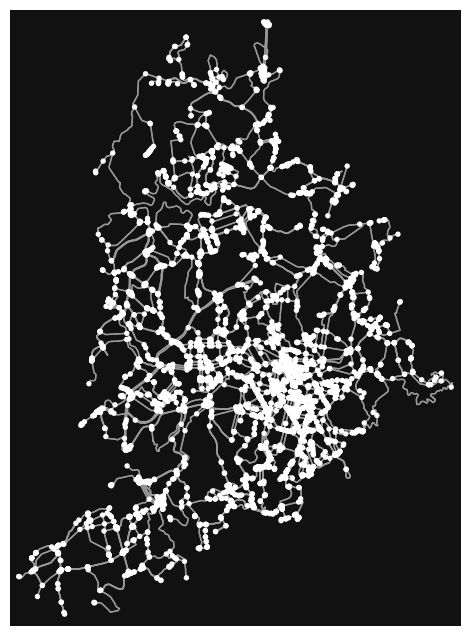

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(G)

In [5]:
num_nodes = len(G.nodes)
num_edges = len(G.edges)

print(f"Grafo com {num_nodes} nós e {num_edges} arestas.")

Grafo com 3834 nós e 11668 arestas.


### Extração de restaurantes

In [6]:
restaurants = ox.features_from_place(place_name, {"amenity": "restaurant"})
restaurant_points = restaurants.representative_point()
nearest_nodes = ox.distance.nearest_nodes(
    G, restaurant_points.x, restaurant_points.y)

useful_tags = ["amenity", "name", "cuisine"]
restaurant_name_to_node = {}

for node, feature in zip(nearest_nodes, restaurants[useful_tags].to_dict(orient="records")):
    feature = {k: v for k, v in feature.items() if pd.notna(v)}
    if "name" in feature:
        restaurant_name_to_node[feature["name"].lower()] = node
    if "restaurants" not in G.nodes[node]:
        G.nodes[node]["restaurants"] = []
    G.nodes[node]["restaurants"].append(feature)

df_restaurantes = pd.DataFrame(
    {"Nome do Restaurante": sorted([nome.title()
                                   for nome in restaurant_name_to_node.keys()])}
)

display(df_restaurantes)

,Nome do Restaurante
0,A Granel
1,A Porca Voadora
2,A Pão De Queijaria
3,Adega Do Sul
4,Adega Minas Gerais Gourmet
...,...
489,Xico Da Carne
490,Xodó
491,Yan Shan Zay
492,Yukai


In [7]:
num_restaurantes = len(df_restaurantes)

print(f"{num_restaurantes} restaurantes extraídos.")

494 restaurantes extraídos.


### Funções de busca

In [8]:
def bfs_path(G, source, target):
    try:
        # Peso não é passado para a função -> faz BFS
        return nx.shortest_path(G, source, target)
    except nx.NetworkXNoPath:
        return None


def a_star_path(G, source, target):
    try:
        return nx.astar_path(G, source, target, weight='length')
    except nx.NetworkXNoPath:
        return None


def shortest_path(source, target):
    def get_node_from_input(user_input):
        if user_input.lower() in restaurant_name_to_node:
            return restaurant_name_to_node[user_input.lower()]
        try:
            point = ox.geocode(user_input + ", " + place_name)
            return ox.distance.nearest_nodes(G, point[1], point[0])
        except Exception as e:
            return None

    source_node = get_node_from_input(source)
    if source_node is None:
        return None, None, f"Local de origem '{source}' não encontrado."

    target_node = get_node_from_input(target)
    if target_node is None:
        return None, None, f"Local de destino '{target}' não encontrado."

    bfs_route = bfs_path(G, source_node, target_node)
    a_star_route = a_star_path(G, source_node, target_node)

    return bfs_route, a_star_route, None

### Visualização da rota

In [9]:
def plot_routes(route1, route2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ox.plot_graph(G, ax=ax1, show=False, close=False,
                  edge_color='gray', node_size=0)
    ox.plot_graph(G, ax=ax2, show=False, close=False,
                  edge_color='gray', node_size=0)

    # Plotar rota BFS em azul
    if route1:
        ox.plot_graph_route(G, route1, ax=ax1, route_color='blue',
                            route_linewidth=4, show=False, close=False)
        ax1.set_title("BFS Route")
    else:
        ax1.set_title("BFS Route (no path)")

    # Plotar rota A* em vermelho
    if route2:
        ox.plot_graph_route(G, route2, ax=ax2, route_color='red',
                            route_linewidth=4, show=False, close=False)
        ax2.set_title("A* Route")
    else:
        ax2.set_title("A* Route (no path)")

    plt.tight_layout()
    plt.show()

### Formatação da rota

In [10]:
def format_route(route):
    if isinstance(route, str):
        return route
    coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in route]
    coords_str = ", ".join([f"({y:.5f}, {x:.5f})" for y, x in coords])
    return f"Path with {len(coords)} points: {coords_str}"

### Gerar gif da rota

In [11]:
def generate_route_gif(G, route, nome_saida="rota.gif", cor="blue"):
    if route is None:
        print("Rota vazia, nada para animar.")
        return

    pasta_gif = "gifs"
    os.makedirs(pasta_gif, exist_ok=True)
    caminho_gif = os.path.join(pasta_gif, nome_saida)

    # Pasta temporária para armazenar imagens
    pasta_frames = "frames_temp"
    os.makedirs(pasta_frames, exist_ok=True)

    filenames = []
    for i in range(1, len(route) + 1):
        fig, ax = ox.plot_graph(
            G, show=False, close=False, edge_color='gray', node_size=0)
        partial_route = route[:i]
        ox.plot_graph_route(G, partial_route, ax=ax, route_color=cor,
                            route_linewidth=3, node_size=10, show=False, close=False)
        filename = os.path.join(pasta_frames, f"frame_{i:03d}.png")
        plt.savefig(filename, dpi=100)
        plt.close(fig)
        filenames.append(filename)

    imagens = [imageio.imread(f) for f in filenames]
    imageio.mimsave(caminho_gif, imagens, duration=0.1)

    # Limpar arquivos temporários
    for f in filenames:
        os.remove(f)
    os.rmdir(pasta_frames)

    print(f"GIF salvo em {caminho_gif}")

### Integração com agente

In [12]:
class RoutePlannerTool(Tool):
    name = "plan_route"
    description = "Use this tool to find a route between two locations in Belo Horizonte, either by name or adress"

    inputs = {
        "source": {"type": "string", "description": "The starting location (e.g. restaurant name or address)"},
        "target": {"type": "string", "description": "The destination location (e.g. restaurant name or address)"},
        "generate_gif": {"type": "boolean", "description": "Whether to generate GIFs for the routes", "default": False, "nullable": True}
    }
    output_type = "string"

    def forward(self, source, target, generate_gif=False):
        source_corrected = self._correct_name(source)
        target_corrected = self._correct_name(target)
        
        bfs_route, a_star_route, erro = shortest_path(
            source_corrected, target_corrected)
        
        if erro:
            return f"Erro: {erro} Tente usar um nome de restaurante conhecido ou endereço válido em Belo Horizonte"
        
        if not bfs_route or not a_star_route:
            return FinalAnswerTool().forward(f"Não foi possível encontrar um caminho entre '{source_corrected}' e '{target_corrected}'")
        
        plot_routes(bfs_route, a_star_route)
        
        if generate_gif:
            nome_bfs = f"bfs_{source_corrected.replace(' ', '_')}_to_{target_corrected.replace(' ', '_')}.gif"
            nome_astar = f"astar_{source_corrected.replace(' ', '_')}_to_{target_corrected.replace(' ', '_')}.gif"
            generate_route_gif(G, bfs_route, nome_saida=nome_bfs, cor="blue")
            generate_route_gif(G, a_star_route, nome_saida=nome_astar, cor="red")
        
        resposta = (f"Rotas encontradas entre '{source_corrected}' e '{target_corrected}':\n\n"
                    f"BFS Route:\n{format_route(bfs_route)}\n\n"
                    f"A* Route:\n{format_route(a_star_route)}")
        
        return FinalAnswerTool().forward(resposta)
    
    # Corrigir erro de digitação nos nomes de restaurantes conhecidos
    def _correct_name(self, name):
        name_lower = name.lower()
        known_names = list(restaurant_name_to_node.keys())
        matches = get_close_matches(name_lower, known_names, n=1, cutoff=0.75)
        return matches[0] if matches else name


model = LiteLLMModel(
    model_id="ollama/qwen3:4b",
    api_base="http://localhost:11434",
    max_ctx=8192,
)

agent = CodeAgent(tools=[RoutePlannerTool()],
                  model=model, add_base_tools=False)

### Testando o agente com prompt livre

Olá! Eu sou um agente inteligente de rotas entre restaurantes para Belo Horizonte.
Posso traçar caminhos entre restaurantes ou locais da cidade usando algoritmos de busca como BFS e A*.
Basta me dizer de onde você quer sair e para onde deseja ir!


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ I want to go from Xapuri to Maria das Tranças with a gif                                                        │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Xapuri", target="Maria das Tranças", generate_gif=True)                               
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

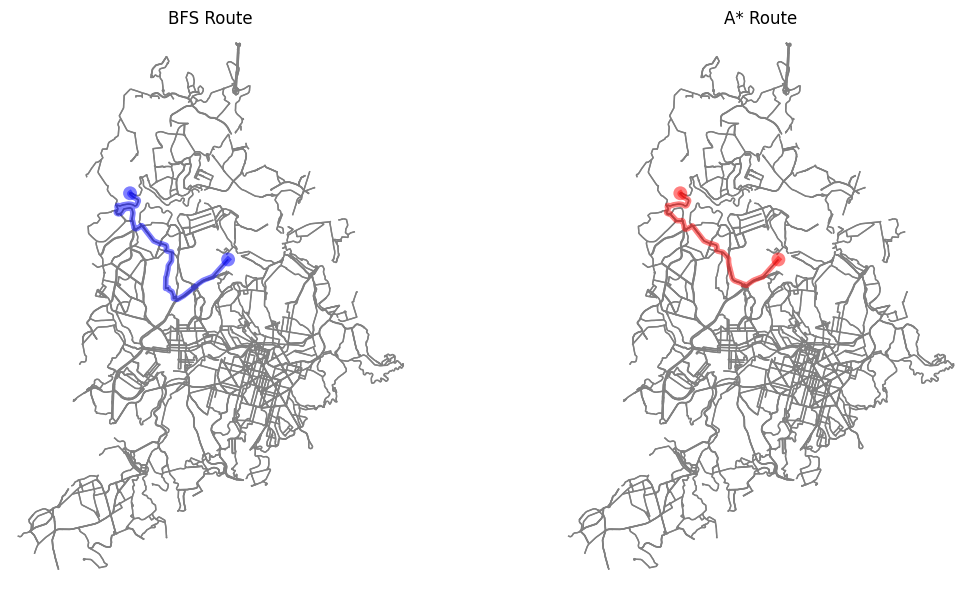

GIF salvo em gifs\bfs_xapuri_to_maria_das_tranças.gif
GIF salvo em gifs\astar_xapuri_to_maria_das_tranças.gif


Out - Final answer: Rotas encontradas entre 'xapuri' e 'maria das tranças':

BFS Route:
Path with 41 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, 
-44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), 
(-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, 
-44.00437), (-19.85443, -44.00428), (-19.85439, -44.00402), (-19.85621, -43.99846), (-19.85754, -43.99840), 
(-19.85774, -43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.85978, -43.99446), (-19.86004, 
-43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, -43.98536), 
(-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), (-19.87145, 
-43.97999), (-19.89119, -43.97914), (-19.89178, -43.97772), (-19.89238, -43.97730), (-19.88778, -43.97035), 
(-19.88720, -43.96956), (-19.88680, -43.96906), (-19.88609, -43.96816), (-19.88248, -43.96086), (-19.88213, 
-43.96050), (-19.87473, -43.95345)

A* Route:
Path with 48 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, 
-44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), 
(-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, 
-44.00437), (-19.85443, -44.00428), (-19.85452, -44.00422), (-19.85455, -44.00423), (-19.85735, -44.00160), 
(-19.85745, -44.00146), (-19.85761, -43.99856), (-19.85771, -43.99855), (-19.85776, -43.99846), (-19.85774, 
-43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.86128, -43.99727), (-19.86125, -43.99640), 
(-19.86004, -43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, 
-43.98536), (-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), 
(-19.87145, -43.97999), (-19.87356, -43.97756), (-19.87376, -43.97739), (-19.87397, -43.97716), (-19.87411, 
-43.97702), (-19.87444, -43.97687), (-19.87737, -43.97660), (-19.87796, -43.97643), (-19.88557, -43.97047), 
(-19.88609, -43.96816), (-19.88248, -43.96086), (-19.88213, -43.96050), (-19.87473, -43.95345)

[Step 1: Duration 131.88 seconds| Input tokens: 2,098 | Output tokens: 251]

"Rotas encontradas entre 'xapuri' e 'maria das tranças':\n\nBFS Route:\nPath with 41 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, -44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), (-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, -44.00437), (-19.85443, -44.00428), (-19.85439, -44.00402), (-19.85621, -43.99846), (-19.85754, -43.99840), (-19.85774, -43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.85978, -43.99446), (-19.86004, -43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, -43.98536), (-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), (-19.87145, -43.97999), (-19.89119, -43.97914), (-19.89178, -43.97772), (-19.89238, -43.97730), (-19.88778, -43.97035), (-19.88720, -43.96956), (-19.88680, -43.96906), (-19.88609, -43.968

In [13]:
print("Olá! Eu sou um agente inteligente de rotas entre restaurantes para Belo Horizonte.")
print("Posso traçar caminhos entre restaurantes ou locais da cidade usando algoritmos de busca como BFS e A*.")
print("Basta me dizer de onde você quer sair e para onde deseja ir!")
prompt = input("\nDigite seu prompt: ")
agent.run(prompt)

### Testando agentes com prompts incorretos

Prompt com nome de restaurante escrito de maneira errada

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How can I go from Xapury to Maria das Trnças?                                                                   │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Xapury", target="Maria das Trnças", generate_gif=False)                               
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

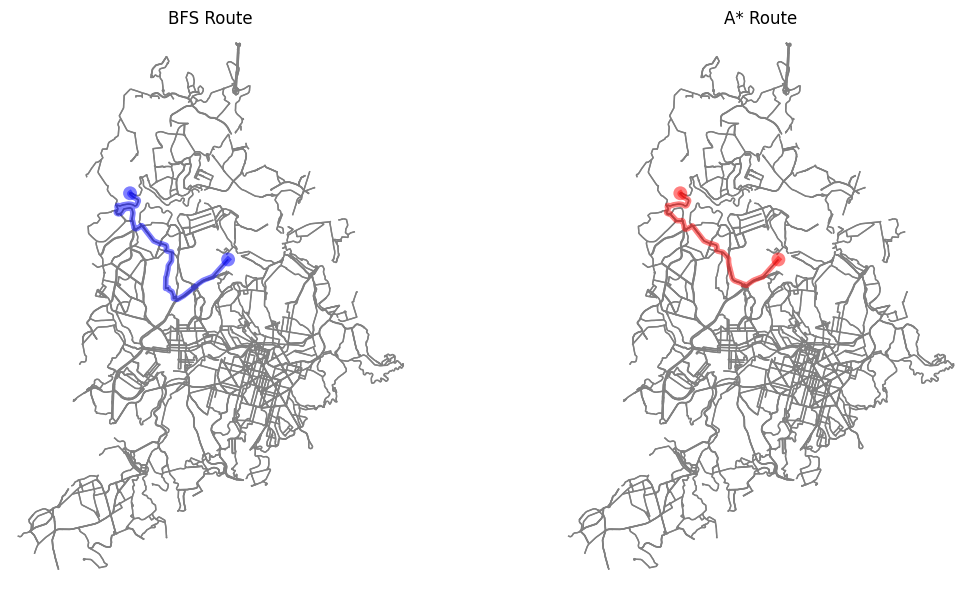

Out - Final answer: Rotas encontradas entre 'xapuri' e 'maria das tranças':

BFS Route:
Path with 41 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, 
-44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), 
(-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, 
-44.00437), (-19.85443, -44.00428), (-19.85439, -44.00402), (-19.85621, -43.99846), (-19.85754, -43.99840), 
(-19.85774, -43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.85978, -43.99446), (-19.86004, 
-43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, -43.98536), 
(-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), (-19.87145, 
-43.97999), (-19.89119, -43.97914), (-19.89178, -43.97772), (-19.89238, -43.97730), (-19.88778, -43.97035), 
(-19.88720, -43.96956), (-19.88680, -43.96906), (-19.88609, -43.96816), (-19.88248, -43.96086), (-19.88213, 
-43.96050), (-19.87473, -43.95345)

A* Route:
Path with 48 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, 
-44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), 
(-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, 
-44.00437), (-19.85443, -44.00428), (-19.85452, -44.00422), (-19.85455, -44.00423), (-19.85735, -44.00160), 
(-19.85745, -44.00146), (-19.85761, -43.99856), (-19.85771, -43.99855), (-19.85776, -43.99846), (-19.85774, 
-43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.86128, -43.99727), (-19.86125, -43.99640), 
(-19.86004, -43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, 
-43.98536), (-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), 
(-19.87145, -43.97999), (-19.87356, -43.97756), (-19.87376, -43.97739), (-19.87397, -43.97716), (-19.87411, 
-43.97702), (-19.87444, -43.97687), (-19.87737, -43.97660), (-19.87796, -43.97643), (-19.88557, -43.97047), 
(-19.88609, -43.96816), (-19.88248, -43.96086), (-19.88213, -43.96050), (-19.87473, -43.95345)

[Step 1: Duration 66.67 seconds| Input tokens: 2,096 | Output tokens: 449]

"Rotas encontradas entre 'xapuri' e 'maria das tranças':\n\nBFS Route:\nPath with 41 points: (-19.84546, -43.99953), (-19.84559, -43.99960), (-19.84583, -43.99952), (-19.85083, -44.00517), (-19.85111, -44.00557), (-19.85118, -44.00559), (-19.85150, -44.00565), (-19.85248, -44.00533), (-19.85313, -44.00544), (-19.85331, -44.00566), (-19.85446, -44.00532), (-19.85454, -44.00505), (-19.85444, -44.00437), (-19.85443, -44.00428), (-19.85439, -44.00402), (-19.85621, -43.99846), (-19.85754, -43.99840), (-19.85774, -43.99836), (-19.86087, -43.99752), (-19.86099, -43.99728), (-19.85978, -43.99446), (-19.86004, -43.99418), (-19.85995, -43.99398), (-19.85989, -43.99383), (-19.86568, -43.98908), (-19.86769, -43.98536), (-19.86771, -43.98524), (-19.87025, -43.98251), (-19.87064, -43.98248), (-19.87109, -43.98180), (-19.87145, -43.97999), (-19.89119, -43.97914), (-19.89178, -43.97772), (-19.89238, -43.97730), (-19.88778, -43.97035), (-19.88720, -43.96956), (-19.88680, -43.96906), (-19.88609, -43.968

In [14]:
agent.run("How can I go from Xapury to Maria das Trnças?")

Prompt com restaurantes que não existem no dicionario

In [15]:
agent.run("Route between Wakanda and Maria das Tranças")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Route between Wakanda and Maria das Tranças                                                                     │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Wakanda", target="Maria das Tranças", generate_gif=False)                             
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Erro: Local de origem 'Wakanda' não encontrado. Tente usar um nome de restaurante conhecido ou 
endereço válido em Belo Horizonte

[Step 1: Duration 25.73 seconds| Input tokens: 2,091 | Output tokens: 180]

"Erro: Local de origem 'Wakanda' não encontrado. Tente usar um nome de restaurante conhecido ou endereço válido em Belo Horizonte"

### Testando agente com diferentes prompts

In [ ]:
test_agent_results = []


def parse_steps(text):
    # Extrai número de passos do texto da rota.
    match = re.search(r"Path with (\d+) points: (.+)", text)
    if not match:
        return 0
    steps = int(match.group(1))
    return steps


def calculate_route_length(G, route):
    if route is None or len(route) < 2:
        return 0
    length = 0
    for u, v in zip(route[:-1], route[1:]):
        if G.has_edge(u, v):
            edge_data = G.get_edge_data(u, v)
            if isinstance(edge_data, dict):
                lengths = [attr.get('length', 0)
                           for attr in edge_data.values()]
                if lengths:
                    length += min(lengths)
    return length


def test_agent_prompt(prompt):
    response = agent.run(prompt)

    bfs_match = re.search(
        r"BFS Route:\s*(Path with \d+ points: .+?)\n\n", response, re.DOTALL)
    astar_match = re.search(
        r"A\* Route:\s*(Path with \d+ points: .+)", response, re.DOTALL)

    bfs_str = bfs_match.group(1) if bfs_match else "Not found"
    astar_str = astar_match.group(1) if astar_match else "Not found"

    bfs_steps = parse_steps(bfs_str)
    astar_steps = parse_steps(astar_str)

    # Extraindo nomes corretos dos locais
    source_match = re.search(
        r"from (.+?) to (.+?)(?: with| without|$)", prompt, re.IGNORECASE)
    if not source_match:
        source_match = re.search(
            r"between (.+?) and (.+?)(?: with| without|$)", prompt, re.IGNORECASE)
    if source_match:
        source = source_match.group(1).strip()
        target = source_match.group(2).strip()
    else:
        source = "Unknown"
        target = "Unknown"

    # Obtendo rotas reais
    bfs_route, a_star_route, erro = shortest_path(source, target)

    bfs_distance = calculate_route_length(G, bfs_route)
    astar_distance = calculate_route_length(G, a_star_route)

    test_agent_results.append({
        "Prompt": prompt,
        "BFS Steps": bfs_steps,
        "BFS Distance (m)": bfs_distance,
        "A* Steps": astar_steps,
        "A* Distance (m)": astar_distance,
    })

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Find a route from A Porca Voadora to A Granel with a gif                                                        │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route_info = plan_route(source="A Porca Voadora", target="A Granel", generate_gif=True)                          
  final_answer(route_info)                                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

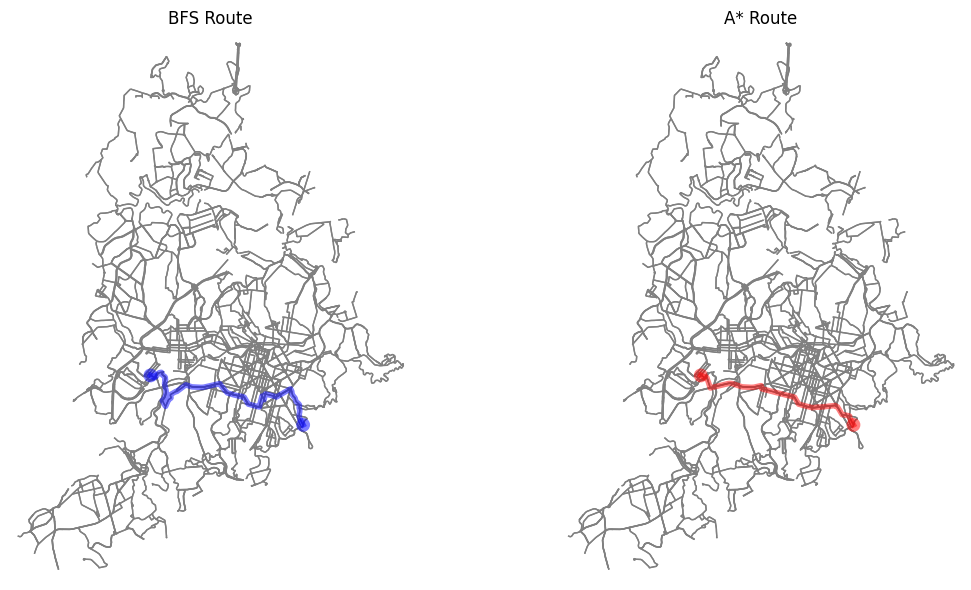

GIF salvo em gifs\bfs_a_porca_voadora_to_a_granel.gif
GIF salvo em gifs\astar_a_porca_voadora_to_a_granel.gif


Out - Final answer: Rotas encontradas entre 'a porca voadora' e 'a granel':

BFS Route:
Path with 48 points: (-19.94781, -43.91818), (-19.94393, -43.91997), (-19.94026, -43.92006), (-19.93901, 
-43.91990), (-19.93194, -43.92411), (-19.93194, -43.92423), (-19.93260, -43.92547), (-19.93277, -43.92577), 
(-19.93454, -43.92895), (-19.93462, -43.92909), (-19.93552, -43.93070), (-19.93540, -43.93079), (-19.93513, 
-43.93193), (-19.93417, -43.93591), (-19.93655, -43.93650), (-19.93669, -43.93653), (-19.93512, -43.93750), 
(-19.93982, -43.93868), (-19.93991, -43.93885), (-19.93960, -43.94014), (-19.93930, -43.94143), (-19.93899, 
-43.94270), (-19.93873, -43.94379), (-19.93541, -43.94652), (-19.93524, -43.94720), (-19.93534, -43.94726), 
(-19.93506, -43.94846), (-19.93504, -43.94855), (-19.93457, -43.95070), (-19.93383, -43.95352), (-19.93335, 
-43.95414), (-19.92973, -43.95717), (-19.92959, -43.95743), (-19.93010, -43.95984), (-19.93047, -43.96154), 
(-19.93013, -43.97335), (-19.93304, -43.97795), (-19.93965, -43.98281), (-19.93709, -43.98436), (-19.92777, 
-43.98282), (-19.92770, -43.98308), (-19.92709, -43.98295), (-19.92462, -43.98480), (-19.92654, -43.98730), 
(-19.92617, -43.98761), (-19.92700, -43.98819), (-19.92597, -43.98956), (-19.92597, -43.98993)

A* Route:
Path with 54 points: (-19.94781, -43.91818), (-19.94393, -43.91997), (-19.94361, -43.92135), (-19.94342, 
-43.92282), (-19.94328, -43.92351), (-19.93993, -43.92561), (-19.93981, -43.92580), (-19.93923, -43.92670), 
(-19.93947, -43.92900), (-19.93958, -43.92993), (-19.93964, -43.93045), (-19.93980, -43.93186), (-19.93985, 
-43.93227), (-19.93989, -43.93287), (-19.93992, -43.93314), (-19.93996, -43.93351), (-19.94002, -43.93419), 
(-19.93993, -43.93442), (-19.94022, -43.93748), (-19.94001, -43.93843), (-19.93995, -43.93869), (-19.93991, 
-43.93885), (-19.93960, -43.94014), (-19.93930, -43.94143), (-19.93899, -43.94270), (-19.93873, -43.94379), 
(-19.93541, -43.94652), (-19.93524, -43.94720), (-19.93494, -43.94843), (-19.93492, -43.94852), (-19.93446, 
-43.95070), (-19.93372, -43.95356), (-19.93344, -43.95493), (-19.93247, -43.95877), (-19.93217, -43.96004), 
(-19.93215, -43.96014), (-19.93213, -43.96024), (-19.93191, -43.96113), (-19.93134, -43.96136), (-19.93047, 
-43.96154), (-19.93013, -43.97335), (-19.92964, -43.97492), (-19.92959, -43.97510), (-19.93104, -43.98354), 
(-19.93121, -43.98417), (-19.93135, -43.98473), (-19.93151, -43.98546), (-19.93138, -43.98550), (-19.92857, 
-43.98647), (-19.92665, -43.98738), (-19.92702, -43.98765), (-19.92700, -43.98819), (-19.92597, -43.98956), 
(-19.92597, -43.98993)

[Step 1: Duration 156.07 seconds| Input tokens: 2,099 | Output tokens: 235]

In [17]:
test_agent_prompt("Find a route from A Porca Voadora to A Granel with a gif")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ How do I go from A Pão De Queijaria to Xico Da Carne with a gif?                                                │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route_info = plan_route(source="A Pão De Queijaria", target="Xico Da Carne", generate_gif=True)                  
  final_answer(route_info)                                                                                         
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

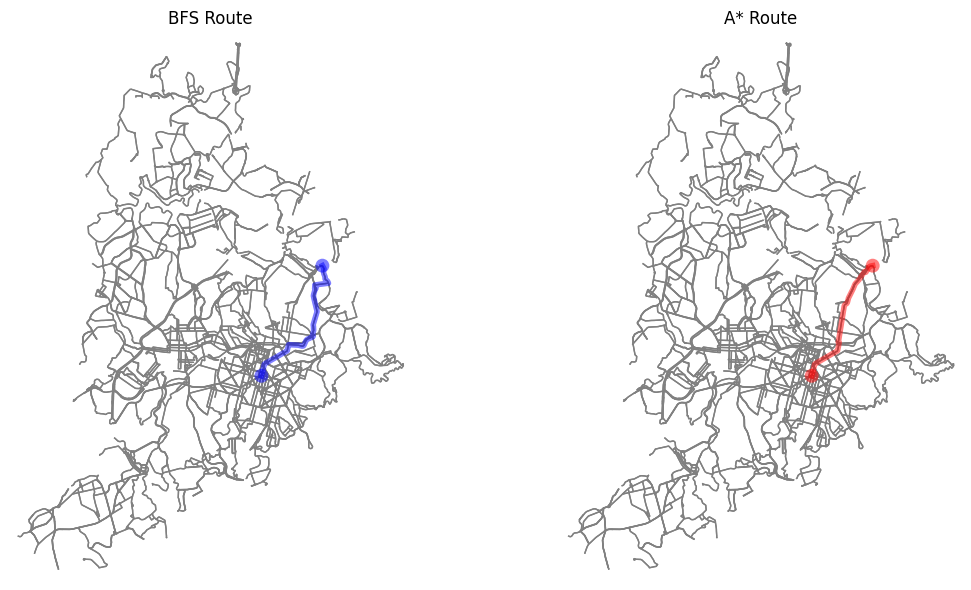

GIF salvo em gifs\bfs_a_pão_de_queijaria_to_xico_da_carne.gif
GIF salvo em gifs\astar_a_pão_de_queijaria_to_xico_da_carne.gif


Out - Final answer: Rotas encontradas entre 'a pão de queijaria' e 'xico da carne':

BFS Route:
Path with 34 points: (-19.92612, -43.93779), (-19.92590, -43.93771), (-19.92468, -43.93738), (-19.92457, 
-43.93735), (-19.92232, -43.93670), (-19.92214, -43.93671), (-19.92191, -43.93668), (-19.92120, -43.93646), 
(-19.92094, -43.93639), (-19.92086, -43.93622), (-19.91911, -43.93300), (-19.91843, -43.93179), (-19.91783, 
-43.93070), (-19.91778, -43.93060), (-19.91602, -43.92746), (-19.91603, -43.92731), (-19.91438, -43.92550), 
(-19.91280, -43.92514), (-19.91236, -43.92498), (-19.90898, -43.91367), (-19.90859, -43.91377), (-19.90848, 
-43.91353), (-19.90839, -43.91359), (-19.90779, -43.91361), (-19.90763, -43.91363), (-19.90364, -43.91347), 
(-19.89559, -43.91217), (-19.89140, -43.91324), (-19.89026, -43.91325), (-19.88734, -43.91277), (-19.88723, 
-43.91217), (-19.88602, -43.91270), (-19.88521, -43.90627), (-19.87746, -43.90912)

A* Route:
Path with 35 points: (-19.92612, -43.93779), (-19.92590, -43.93771), (-19.92468, -43.93738), (-19.92457, 
-43.93735), (-19.92232, -43.93670), (-19.92214, -43.93671), (-19.92191, -43.93668), (-19.92120, -43.93646), 
(-19.92094, -43.93639), (-19.92086, -43.93622), (-19.91911, -43.93300), (-19.91843, -43.93179), (-19.91783, 
-43.93070), (-19.91778, -43.93060), (-19.91602, -43.92746), (-19.91603, -43.92731), (-19.91438, -43.92550), 
(-19.91280, -43.92514), (-19.91236, -43.92511), (-19.91161, -43.92494), (-19.91150, -43.92489), (-19.91132, 
-43.92533), (-19.90684, -43.92454), (-19.90087, -43.92353), (-19.89239, -43.92070), (-19.89202, -43.92061), 
(-19.89128, -43.92023), (-19.88639, -43.91781), (-19.88626, -43.91776), (-19.88278, -43.91493), (-19.88081, 
-43.91357), (-19.87998, -43.91299), (-19.88019, -43.91267), (-19.88037, -43.91234), (-19.87746, -43.90912)

[Step 1: Duration 101.84 seconds| Input tokens: 2,103 | Output tokens: 240]

In [18]:
test_agent_prompt("How do I go from A Pão De Queijaria to Xico Da Carne with a gif?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Find a path between Adega do Sul and Dona Lucinha without a gif                                                 │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Adega do Sul", target="Dona Lucinha", generate_gif=False)                             
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

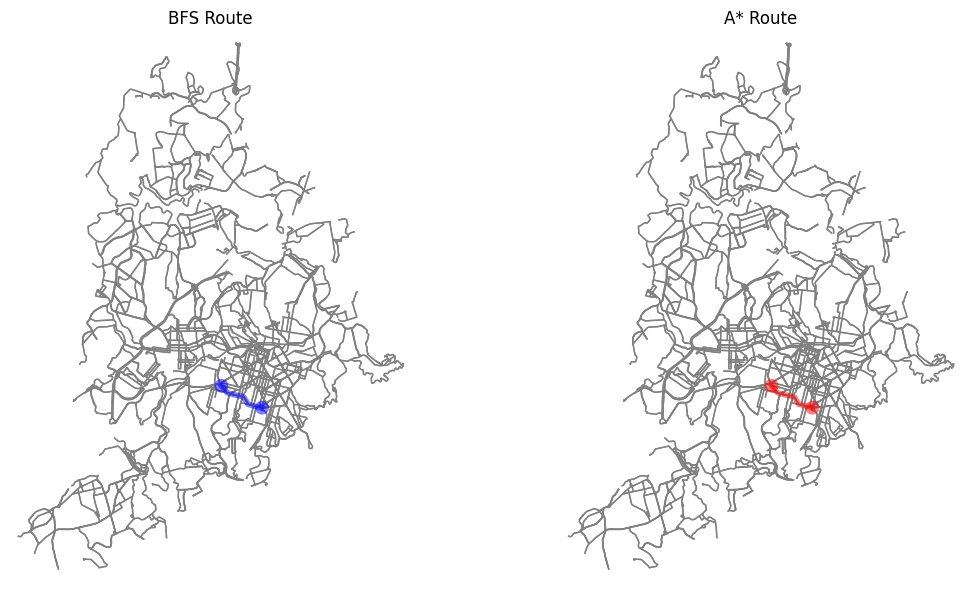

Out - Final answer: Rotas encontradas entre 'adega do sul' e 'dona lucinha':

BFS Route:
Path with 15 points: (-19.93055, -43.95657), (-19.93372, -43.95356), (-19.93446, -43.95070), (-19.93492, 
-43.94852), (-19.93494, -43.94843), (-19.93524, -43.94720), (-19.93541, -43.94652), (-19.93551, -43.94656), 
(-19.93878, -43.94398), (-19.93907, -43.94280), (-19.93941, -43.94146), (-19.93972, -43.94017), (-19.93989, 
-43.93949), (-19.94035, -43.93752), (-19.94022, -43.93748)

A* Route:
Path with 15 points: (-19.93055, -43.95657), (-19.93372, -43.95356), (-19.93446, -43.95070), (-19.93492, 
-43.94852), (-19.93494, -43.94843), (-19.93524, -43.94720), (-19.93541, -43.94652), (-19.93873, -43.94379), 
(-19.93899, -43.94270), (-19.93930, -43.94143), (-19.93960, -43.94014), (-19.93991, -43.93885), (-19.93995, 
-43.93869), (-19.94001, -43.93843), (-19.94022, -43.93748)

[Step 1: Duration 45.79 seconds| Input tokens: 2,098 | Output tokens: 293]

In [19]:
test_agent_prompt("Find a path between Adega do Sul and Dona Lucinha without a gif")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What is the best route from Yan Shan Zay to Yukai without a gif?                                                │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Yan Shan Zay", target="Yukai", generate_gif=False)                                    
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

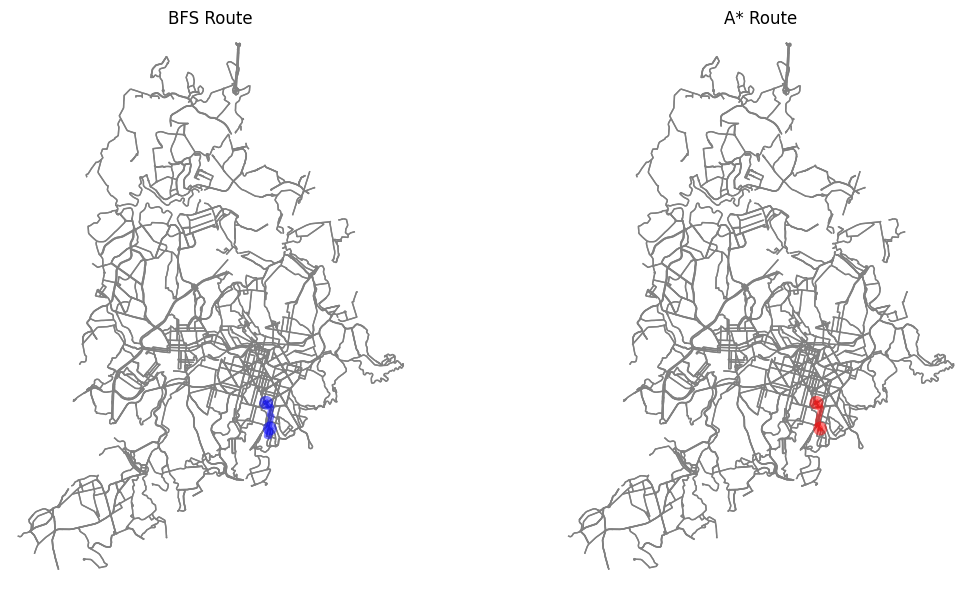

Out - Final answer: Rotas encontradas entre 'yan shan zay' e 'yukai':

BFS Route:
Path with 15 points: (-19.93807, -43.93553), (-19.93817, -43.93548), (-19.93989, -43.93404), (-19.93983, 
-43.93337), (-19.93992, -43.93314), (-19.94147, -43.93346), (-19.94345, -43.93400), (-19.94352, -43.93391), 
(-19.94375, -43.93294), (-19.94639, -43.93364), (-19.94858, -43.93428), (-19.94876, -43.93433), (-19.94887, 
-43.93436), (-19.95304, -43.93412), (-19.94947, -43.93382)

A* Route:
Path with 20 points: (-19.93807, -43.93553), (-19.93813, -43.93563), (-19.93822, -43.93558), (-19.93993, 
-43.93442), (-19.94002, -43.93419), (-19.94173, -43.93375), (-19.94301, -43.93409), (-19.94381, -43.93431), 
(-19.94608, -43.93493), (-19.94616, -43.93483), (-19.94658, -43.93483), (-19.94751, -43.93510), (-19.94766, 
-43.93503), (-19.94783, -43.93494), (-19.94865, -43.93444), (-19.94866, -43.93439), (-19.94876, -43.93433), 
(-19.94926, -43.93385), (-19.94935, -43.93382), (-19.94947, -43.93382)

[Step 1: Duration 37.82 seconds| Input tokens: 2,098 | Output tokens: 247]

In [20]:
test_agent_prompt("What is the best route from Yan Shan Zay to Yukai without a gif?")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Plan a route from Xodó to Bolão without a gif                                                                   │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Xodó", target="Bolão", generate_gif=False)                                            
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

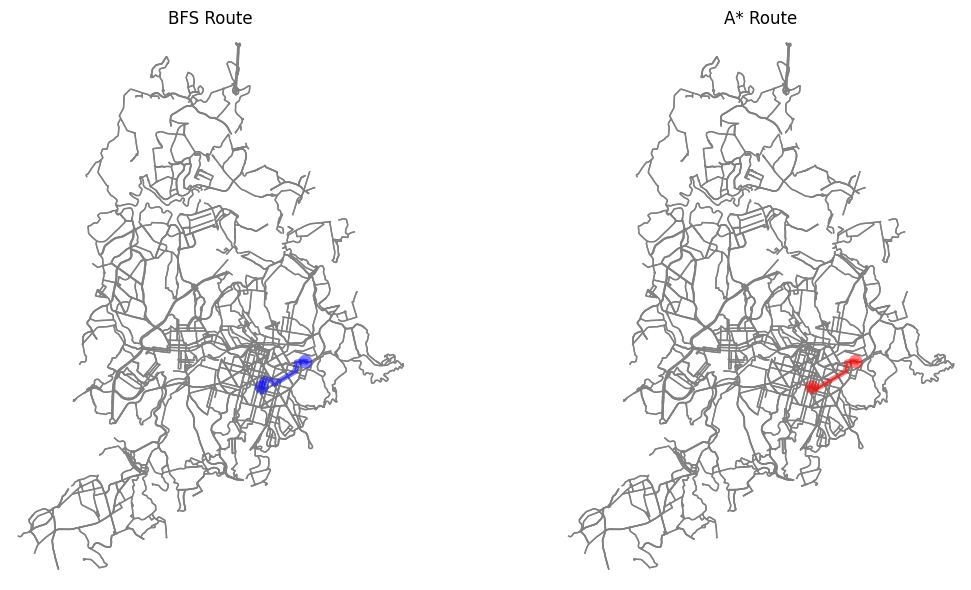

Out - Final answer: Rotas encontradas entre 'xodó' e 'Bolão':

BFS Route:
Path with 20 points: (-19.93118, -43.93764), (-19.92741, -43.93668), (-19.92770, -43.93544), (-19.92805, 
-43.93414), (-19.92830, -43.93300), (-19.92820, -43.93285), (-19.92978, -43.93187), (-19.92890, -43.93026), 
(-19.92822, -43.92906), (-19.92802, -43.92871), (-19.92637, -43.92574), (-19.92623, -43.92550), (-19.92616, 
-43.92537), (-19.92443, -43.92225), (-19.92433, -43.92209), (-19.92208, -43.92147), (-19.92196, -43.92144), 
(-19.92018, -43.92139), (-19.91985, -43.91933), (-19.91988, -43.91713)

A* Route:
Path with 25 points: (-19.93118, -43.93764), (-19.93125, -43.93733), (-19.93139, -43.93663), (-19.93142, 
-43.93652), (-19.93145, -43.93641), (-19.93169, -43.93527), (-19.93159, -43.93509), (-19.93151, -43.93494), 
(-19.93068, -43.93345), (-19.93066, -43.93334), (-19.92988, -43.93203), (-19.92978, -43.93187), (-19.92890, 
-43.93026), (-19.92822, -43.92906), (-19.92802, -43.92871), (-19.92637, -43.92574), (-19.92623, -43.92550), 
(-19.92616, -43.92537), (-19.92443, -43.92225), (-19.92433, -43.92209), (-19.92208, -43.92147), (-19.92196, 
-43.92144), (-19.92018, -43.92139), (-19.91985, -43.91933), (-19.91988, -43.91713)

[Step 1: Duration 34.62 seconds| Input tokens: 2,095 | Output tokens: 223]

In [21]:
test_agent_prompt("Plan a route from Xodó to Bolão without a gif")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Plan a route from Tudo na Brasa to Anella with a gif                                                            │
│                                                                                                                 │
╰─ LiteLLMModel - ollama/qwen3:4b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  route = plan_route(source="Tudo na Brasa", target="Anella", generate_gif=True)                                   
  final_answer(route)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

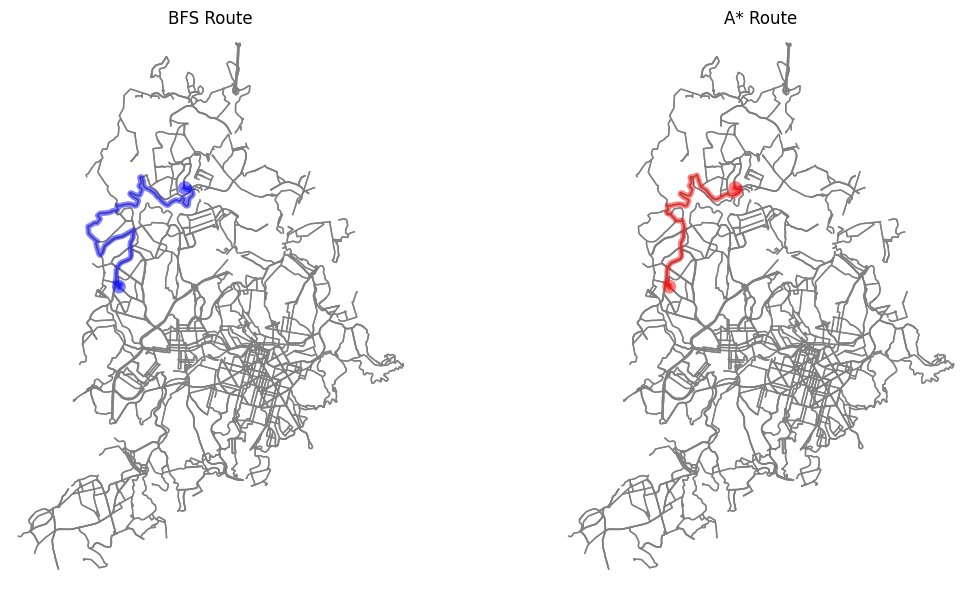

GIF salvo em gifs\bfs_Tudo_na_Brasa_to_anella.gif
GIF salvo em gifs\astar_Tudo_na_Brasa_to_anella.gif


Out - Final answer: Rotas encontradas entre 'Tudo na Brasa' e 'anella':

BFS Route:
Path with 41 points: (-19.88671, -44.00478), (-19.88535, -44.00524), (-19.88501, -44.00619), (-19.88495, 
-44.00648), (-19.87842, -44.00552), (-19.87821, -44.00540), (-19.87043, -43.99928), (-19.86956, -43.99935), 
(-19.86933, -43.99936), (-19.86242, -43.99807), (-19.86171, -43.99805), (-19.87275, -44.01369), (-19.86894, 
-44.01519), (-19.86667, -44.01494), (-19.86465, -44.01749), (-19.86245, -44.01905), (-19.85370, -44.00851), 
(-19.85367, -44.00838), (-19.85345, -44.00814), (-19.85307, -44.00606), (-19.85302, -44.00568), (-19.85301, 
-44.00564), (-19.85248, -44.00533), (-19.85150, -44.00565), (-19.85118, -44.00559), (-19.85111, -44.00557), 
(-19.85083, -44.00517), (-19.84583, -43.99952), (-19.84562, -43.99950), (-19.84553, -43.99944), (-19.84538, 
-43.99889), (-19.83828, -43.99421), (-19.83854, -43.99408), (-19.83867, -43.99396), (-19.83878, -43.99385), 
(-19.84429, -43.97024), (-19.84399, -43.97132), (-19.84389, -43.97165), (-19.84367, -43.97235), (-19.84362, 
-43.97254), (-19.84317, -43.97371)

A* Route:
Path with 71 points: (-19.88671, -44.00478), (-19.88635, -44.00518), (-19.88539, -44.00627), (-19.88501, 
-44.00619), (-19.87854, -44.00529), (-19.87842, -44.00552), (-19.87821, -44.00540), (-19.87043, -43.99928), 
(-19.86956, -43.99935), (-19.86933, -43.99936), (-19.86242, -43.99807), (-19.86171, -43.99805), (-19.86112, 
-43.99782), (-19.86108, -43.99781), (-19.85776, -43.99846), (-19.85771, -43.99855), (-19.85761, -43.99856), 
(-19.85745, -44.00146), (-19.85735, -44.00160), (-19.85455, -44.00423), (-19.85452, -44.00422), (-19.85443, 
-44.00428), (-19.85444, -44.00437), (-19.85454, -44.00505), (-19.85446, -44.00532), (-19.85331, -44.00566), 
(-19.85313, -44.00544), (-19.85248, -44.00533), (-19.85150, -44.00565), (-19.85118, -44.00559), (-19.85111, 
-44.00557), (-19.85083, -44.00517), (-19.84583, -43.99952), (-19.84562, -43.99950), (-19.84553, -43.99944), 
(-19.84538, -43.99889), (-19.83828, -43.99421), (-19.83848, -43.99394), (-19.83853, -43.99388), (-19.83755, 
-43.99200), (-19.83748, -43.99179), (-19.83749, -43.99176), (-19.83779, -43.99159), (-19.83946, -43.99099), 
(-19.83973, -43.99086), (-19.83988, -43.99079), (-19.84009, -43.99076), (-19.84208, -43.99005), (-19.84235, 
-43.98986), (-19.84236, -43.98981), (-19.84250, -43.98975), (-19.84252, -43.98976), (-19.84274, -43.98953), 
(-19.84399, -43.98758), (-19.84709, -43.98038), (-19.84708, -43.98035), (-19.84589, -43.97805), (-19.84586, 
-43.97752), (-19.84603, -43.97680), (-19.84620, -43.97640), (-19.84647, -43.97566), (-19.84656, -43.97512), 
(-19.84635, -43.97391), (-19.84622, -43.97360), (-19.84504, -43.97181), (-19.84445, -43.97148), (-19.84399, 
-43.97132), (-19.84389, -43.97165), (-19.84367, -43.97235), (-19.84362, -43.97254), (-19.84317, -43.97371)

[Step 1: Duration 156.43 seconds| Input tokens: 2,097 | Output tokens: 251]

In [22]:
test_agent_prompt("Plan a route from Tudo na Brasa to Anella with a gif")

In [23]:
df_comparison = pd.DataFrame(test_agent_results)
display(df_comparison)

,Prompt,BFS Steps,BFS Distance (m),A* Steps,A* Distance (m)
0,Find a route from A Porca Voadora to A Granel ...,48,12725.554074,54,8964.572214
1,How do I go from A Pão De Queijaria to Xico Da...,34,8020.724684,35,6742.289182
2,Find a path between Adega do Sul and Dona Luci...,15,2427.999374,15,2400.406750
3,What is the best route from Yan Shan Zay to Yu...,15,2468.224656,20,1474.543474
4,Plan a route from Xodó to Bolão without a gif,20,3164.952279,25,2781.171498
5,Plan a route from Tudo na Brasa to Anella with...,41,17476.807673,71,12011.908383


In [24]:
bfs_steps_list = [row['BFS Steps']
                  for row in test_agent_results if row['BFS Steps'] > 0]
astar_steps_list = [row['A* Steps']
                    for row in test_agent_results if row['A* Steps'] > 0]

if bfs_steps_list:
    print(
        f"Média de passos BFS: {sum(bfs_steps_list)/len(bfs_steps_list):.2f}")
if astar_steps_list:
    print(
        f"Média de passos A*: {sum(astar_steps_list)/len(astar_steps_list):.2f}")

Média de passos BFS: 28.83
Média de passos A*: 36.67


In [25]:
bfs_distance_list = [row['BFS Distance (m)']
                     for row in test_agent_results if row['BFS Distance (m)'] > 0]
astar_distance_list = [row['A* Distance (m)']
                       for row in test_agent_results if row['A* Distance (m)'] > 0]

if bfs_distance_list:
    print(
        f"Média de distância BFS: {sum(bfs_distance_list)/len(bfs_distance_list):.2f} metros")
if astar_distance_list:
    print(
        f"Média de distância A*: {sum(astar_distance_list)/len(astar_distance_list):.2f} metros")

Média de distância BFS: 7714.04 metros
Média de distância A*: 5729.15 metros


In [26]:
df_comparison['Diff Steps'] = df_comparison['BFS Steps'] - df_comparison['A* Steps']
df_comparison['Diff Distance (m)'] = df_comparison['BFS Distance (m)'] - df_comparison['A* Distance (m)']

In [27]:
print(df_comparison[['Diff Steps', 'Diff Distance (m)']].describe())

       Diff Steps  Diff Distance (m)
count    6.000000           6.000000
mean    -7.833333        1984.895206
std     11.125047        2151.329988
min    -30.000000          27.592623
25%     -5.750000         536.255882
50%     -5.000000        1136.058342
75%     -2.000000        3140.345270
max      0.000000        5464.899290


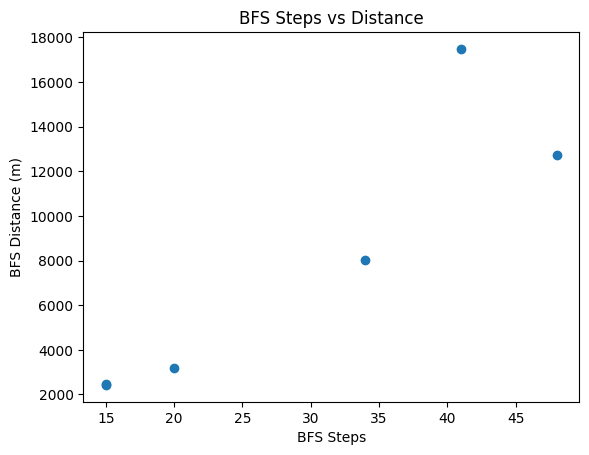

In [28]:
plt.scatter(df_comparison['BFS Steps'], df_comparison['BFS Distance (m)'])
plt.xlabel('BFS Steps')
plt.ylabel('BFS Distance (m)')
plt.title('BFS Steps vs Distance')
plt.show()

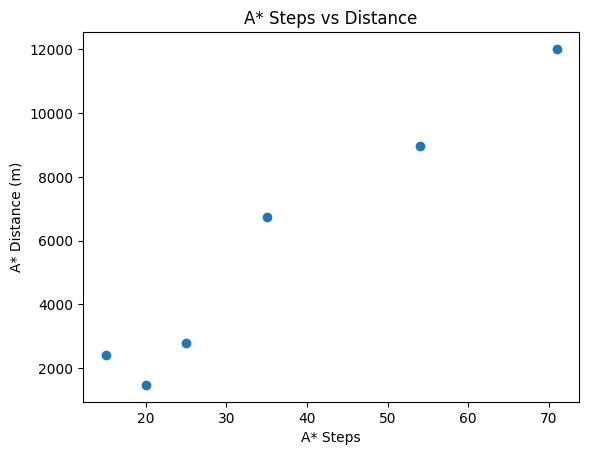

In [32]:
plt.scatter(df_comparison['A* Steps'], df_comparison['A* Distance (m)'])
plt.xlabel('A* Steps')
plt.ylabel('A* Distance (m)')
plt.title('A* Steps vs Distance')
plt.show()

<Axes: >

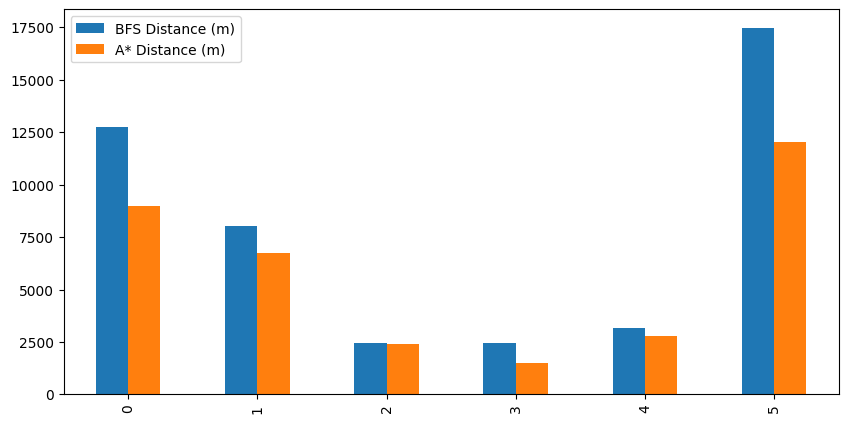

In [30]:
df_comparison[['BFS Distance (m)', 'A* Distance (m)']
              ].plot(kind='bar', figsize=(10, 5))